## Importing Libraries

In [407]:
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from prettytable import PrettyTable
from sklearn.metrics import silhouette_score

## Loading Dataset

In [391]:
def load_dataset(dataset_name, dataset_path = "Dataset\\"):
    df = pd.read_csv(dataset_path + dataset_name)
    return df
    
customers_df = load_dataset(dataset_name = "Customers.csv")
transactions_df = load_dataset(dataset_name = "Transactions.csv")

## Dataset

I combined the Customers & Transaction Dataframe to form a Single Dataframe  using Inner join using common Column: CustomerID

In [392]:
dataset = pd.merge(left = customers_df, right = transactions_df, how = "inner", on = "CustomerID")
print('No of Rows: ', dataset.shape[0])
print('No of Columns: ', dataset.shape[1])

dataset.head(3)

No of Rows:  1000
No of Columns:  10


,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47


## Feature Extraction/Generation

### Drop Unnecessary Columns

In [393]:
dataset.drop(['CustomerName'], axis = 1, inplace = True)

### Calculating No of Transactions, Total Amount, Quantity per Customer

In [394]:
# No of Transactions per Customer
transactionsDf = dataset.groupby('CustomerID')['TransactionID'].count().reset_index()
transactionsDf.columns = ['CustomerID', 'NumTransactions']

#Total Amount per Customer
amountDf = dataset.groupby('CustomerID')['TotalValue'].sum().reset_index()
amountDf.columns = ['CustomerID', 'TotalAmount']

#Total Quantity per Customer
quantityDf = dataset.groupby('CustomerID')['Quantity'].sum().reset_index()
quantityDf.columns = ['CustomerID', 'TotalQuantity']

#Region
regionDf = dataset.groupby('CustomerID')['Region'].first().reset_index()

In [395]:
combDf = pd.merge(left = transactionsDf, right = amountDf, on = 'CustomerID', how = 'inner')
combDf2 = pd.merge(left = combDf, right = dataset['CustomerID'].drop_duplicates(), on = 'CustomerID', how = 'inner')
newDf = pd.merge(left = combDf2, right = quantityDf, on = 'CustomerID', how='left')

newDf['SignupToFirstTransaction'] = (pd.to_datetime(dataset['TransactionDate']) - pd.to_datetime(dataset['SignupDate'])).dt.days

### Converting Categorical Attribute To Numeric Attribute

In [396]:
newDf['Region'] = regionDf['Region']
dummyDataset = pd.get_dummies(newDf['Region'], drop_first = True)
newDf = pd.concat([dummyDataset, newDf], axis = 1)
newDf.drop(['Region', 'CustomerID'], axis = 1, inplace = True)
newDf.head(3)

,Europe,North America,South America,NumTransactions,TotalAmount,TotalQuantity,SignupToFirstTransaction
0,0,0,1,5,3354.52,12,558
1,0,0,0,4,1862.74,10,800
2,0,0,1,4,2725.38,14,638


### Feature Scaling

In [397]:
scaler = StandardScaler()
scaledData = scaler.fit_transform(newDf)
scaledDf = pd.DataFrame(scaledData, columns = ['Europe', 'North America', 'South America', 'NumTransactions', 'TotalAmount', 'TotalQuantity', 'SignupToFirstTransaction'])

## KMeans Clustering

Different number of clusters are used from 2 to 10

In [406]:
sum_of_square_dis = []
clusters = list(range(2, 11))

table = PrettyTable()
table.field_names = ["Clusters", "DB Index", "Sum of Square", "Silhouette Score"]
table.title = "Table with Different Metrics"

for cluster in clusters:    
    model = KMeans(n_clusters = cluster, random_state = 8)
    kmeans_clusters = model.fit_predict(scaledDf)
    sum_of_square_dis.append(model.inertia_)
    
    dbIndex = davies_bouldin_score(scaledDf, kmeans_clusters)
    silhouette = silhouette_score(scaledDf, kmeans_clusters)
    
    table.add_row([cluster, round(dbIndex, 2), round(model.inertia_, 2), round(silhouette, 2)])
    
print(table)

+--------------------------------------------------------+
|              Table with Different Metrics              |
+----------+----------+---------------+------------------+
| Clusters | DB Index | Sum of Square | Silhouette Score |
+----------+----------+---------------+------------------+
|    2     |   1.64   |    1036.29    |       0.23       |
|    3     |   1.41   |     841.77    |       0.26       |
|    4     |   1.21   |     663.91    |       0.32       |
|    5     |   1.22   |     573.0     |       0.31       |
|    6     |   1.24   |     523.12    |       0.3        |
|    7     |   1.2    |     474.06    |       0.3        |
|    8     |   1.19   |     420.06    |       0.31       |
|    9     |   1.12   |     386.29    |       0.32       |
|    10    |   1.09   |     362.15    |       0.31       |
+----------+----------+---------------+------------------+


## Elbow Curve

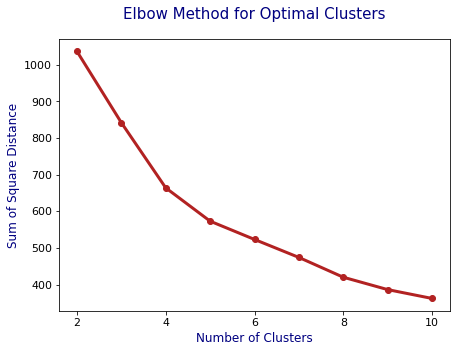

In [418]:
plt.figure(figsize = (7, 5))

plt.plot(clusters, sum_of_square_dis, 'bx-', color = 'firebrick', linewidth = 3, marker = 'o')
plt.title('Elbow Method for Optimal Clusters', size=15, color = 'navy', loc ='center', pad = 20)
plt.xlabel('Number of Clusters', fontsize = 12, color = 'navy')
plt.xticks([2, 4, 6, 8, 10])
plt.ylabel('Sum of Square Distance', fontsize = 12, color = 'navy')
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

### Scatter Plot Representing Clusters

C:\Users\Dell\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Dell\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


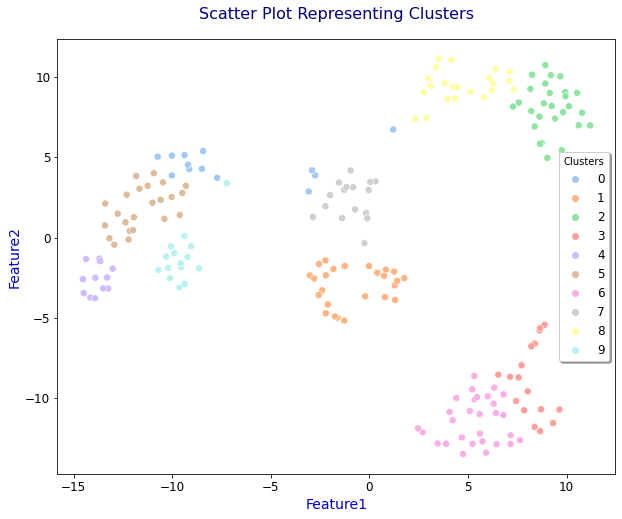

In [419]:
# clustering_labels
model = KMeans(n_clusters = 10, random_state = 8)
clustering_labels = model.fit_predict(scaledDf)

tsne = TSNE(n_components = 2, random_state = 0)

tsneSamples = tsne.fit_transform(scaledDf)
tsneClusteredDf = pd.DataFrame(data = tsneSamples, columns = ['Feature1', 'Feature2'])

tsneClusteredDf['Clusters'] = clustering_labels

plt.figure(figsize=(10,8))
s = sns.scatterplot(x = 'Feature1', y = 'Feature2', data = tsneClusteredDf, hue = 'Clusters', s = 50, palette='pastel', legend='full')
s.legend(fontsize = 'large', shadow = True, facecolor = 'white', title = 'Clusters')
plt.title("Scatter Plot Representing Clusters", size=16, color='navy', loc ='center', pad = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Feature1', fontsize = 14, color = 'mediumblue')
plt.ylabel('Feature2', fontsize = 14, color = 'mediumblue')